In [565]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from time import time
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

%matplotlib inline 
# Lloyds algorithm for k-means
def kmeans(X, k, max_iter = 100, tolerance = 10**(-3), Seed=None):
    n_samples = X.shape[0]
    n_features = X.shape[1]
    classifications = np.zeros(n_samples, dtype = np.int64)

  # Choose k sapmple as initial cluster centroids randomly
    np.random.seed(Seed) ########
    I = np.random.choice(n_samples, k)
    #print(I)
    centroids = X[I, :]

    loss = 0
    for m in range(0, max_iter):
        
        # Compute the classifications
        for i in range(0, n_samples): #pick one sample
            distances = np.zeros(k)
            for j in range(0, k):  #calc distances from k clusters
                distances[j] = np.sqrt(np.sum(np.power(X[i, :] - centroids[j], 2)))
            classifications[i] = np.argmin(distances) #assign to cluster with min distances 
            
        # Compute the new centroids and new loss
        new_centroids = np.zeros((k, n_features))
        new_loss = 0
        for j in range(0, k):
            # compute centroids
            J = np.where(classifications == j)
            X_C = X[J]
            new_centroids[j] = X_C.mean(axis = 0)
            # Compute loss
            for i in range(0, X_C.shape[0]):
                new_loss += np.sum(np.power(X_C[i, :] - centroids[j], 2))

            # Stopping criterion            
            if np.abs(loss - new_loss) < tolerance:
                return new_centroids, classifications, new_loss
        centroids = new_centroids
        loss = new_loss
    
    print("Failed to converge!")
    return centroids, classifications, loss

def kmeans_MM(X, X_complete, sam_index, ele_index, k, max_iter = 100, tolerance = 10**(-3), Seed=None):
    n_samples = X.shape[0]
    n_features = X.shape[1]
    classifications = np.zeros(n_samples, dtype = np.int64)

  # Choose k sapmple as initial cluster centroids randomly
    np.random.seed(Seed) ########
    #I = np.random.choice(n_samples, k)
    #centroids = X[I, :]
    I = np.random.choice(X_complete.shape[0], k)
    #print(I)
    centroids = X_complete[I, :]
    #print(X)
    
    #replace missing values with corresponding element of one of selected initial cluster centroids randomly
    for j in range(len(sam_index)):
        w = np.random.choice(centroids.shape[0], 1)
        X[sam_index[j], ele_index[j]]= centroids[w, ele_index[j]]
    #print(X)
    
    loss = 0
    for m in range(0, max_iter):
        
        # Compute the classifications
        for i in range(0, n_samples): #pick one sample
            distances = np.zeros(k)
            for j in range(0, k):  #calc distances from k clusters
                distances[j] = np.sqrt(np.sum(np.power(X[i, :] - centroids[j], 2)))
            classifications[i] = np.argmin(distances) #assign to cluster with min distances 
            
        # Compute the new centroids and new loss
        new_centroids = np.zeros((k, n_features))
        new_loss = 0
        for j in range(0, k):
            # compute centroids
            J = np.where(classifications == j)
            X_C = X[J]
            new_centroids[j] = X_C.mean(axis = 0)
            # Compute loss
            for i in range(0, X_C.shape[0]):
                new_loss += np.sum(np.power(X_C[i, :] - centroids[j], 2))

            # Stopping criterion            
            if np.abs(loss - new_loss) < tolerance:
                return new_centroids, classifications, new_loss
        centroids = new_centroids
        loss = new_loss
        #update missing values with corresponding element of assigned cluster centroids
        for j in range(len(sam_index)):
            X[sam_index[j], ele_index[j]]= centroids[classifications[sam_index[j]], ele_index[j]]
        
    
    print("Failed to converge!")
    return centroids, classifications, loss

def kmeans_predict(test, centroids):
    predicts = np.zeros(test.shape[0], dtype = np.int64)
    for i in range(0, test.shape[0]): #pick one sample
            distances = np.zeros(centroids.shape[0])
            for j in range(0, centroids.shape[0]):  #calc distances from k clusters
                distances[j] = np.sqrt(np.sum(np.power(test[i, :] - centroids[j], 2)))
            predicts[i] = np.argmin(distances) #assign to cluster with min distances 
    return predicts

def Create_Incompelete_DATASET(a, percentagofmisseddata=50, seed_number2=None):
    numberoftotalelements=a.shape[0]*a.shape[1]
    numberofmissedelements=int(np.ceil(percentagofmisseddata*numberoftotalelements/100))
    np.random.seed(seed_number2) ########
    I = np.sort(np.random.choice(numberoftotalelements, numberofmissedelements, replace=False))
    #print(a)
    #print('number of total sapmles * elements', numberoftotalelements, 'number of missed elements', numberofmissedelements)
    #print('I', I)
    sample_index, element_index=np.unravel_index(I, np.shape(a), order='F')
    #print(sample_index, element_index)
    for i in range(len(I)):
        #print('index', I[i], 'unravel_index', sample_index[i] , element_index[i], 'value', a[sample_index[i], element_index[i]])
        a[sample_index[i], element_index[i]]=-100
    return a, sample_index, element_index

def Separate_Complete_Data(b, d, noisy_index):
    c=np.delete(b, noisy_index, 0)
    e=np.delete(d, sample_index)
    return c, e

def bench_k_means(fit_time, name, data_name, data, labels, y_pred):
    results = [data_name, name, fit_time]
    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, y_pred) for m in clustering_metrics]
    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            y_pred,
            metric="euclidean",
            sample_size=500,
        )
    ]
    # Show the results
    formatter_result = (
        "{:9s}\t{:24s}\t{:.2f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

__________________________________________________________________________________________________________
dataset		algorithm			time	homo	compl	v-meas	ARI	AMI	silhouette
noisy_circles	Dataset                 	0.00	1.000	1.000	1.000	1.000	1.000	0.111
noisy_circles	K-means on Complete Data	0.09	0.000	0.000	0.000	-0.002	-0.001	0.352
noisy_circles	MM K-means on 90% Data  	0.13	0.000	0.000	0.000	-0.002	-0.001	0.355
noisy_circles	MM K-means on 70% Data  	0.12	0.000	0.000	0.000	-0.002	-0.001	0.355
noisy_circles	MM K-means on 50% Data  	0.16	0.000	0.000	0.000	-0.002	-0.001	0.347
noisy_moons	Dataset                 	0.00	1.000	1.000	1.000	1.000	1.000	0.387
noisy_moons	K-means on Complete Data	0.10	0.385	0.385	0.385	0.483	0.384	0.497
noisy_moons	MM K-means on 90% Data  	0.08	0.385	0.385	0.385	0.483	0.384	0.497
noisy_moons	MM K-means on 70% Data  	0.17	0.386	0.386	0.386	0.483	0.385	0.495
noisy_moons	MM K-means on 50% Data  	0.21	0.387	0.394	0.391	0.467	0.390	0.484
varied   	Dataset               

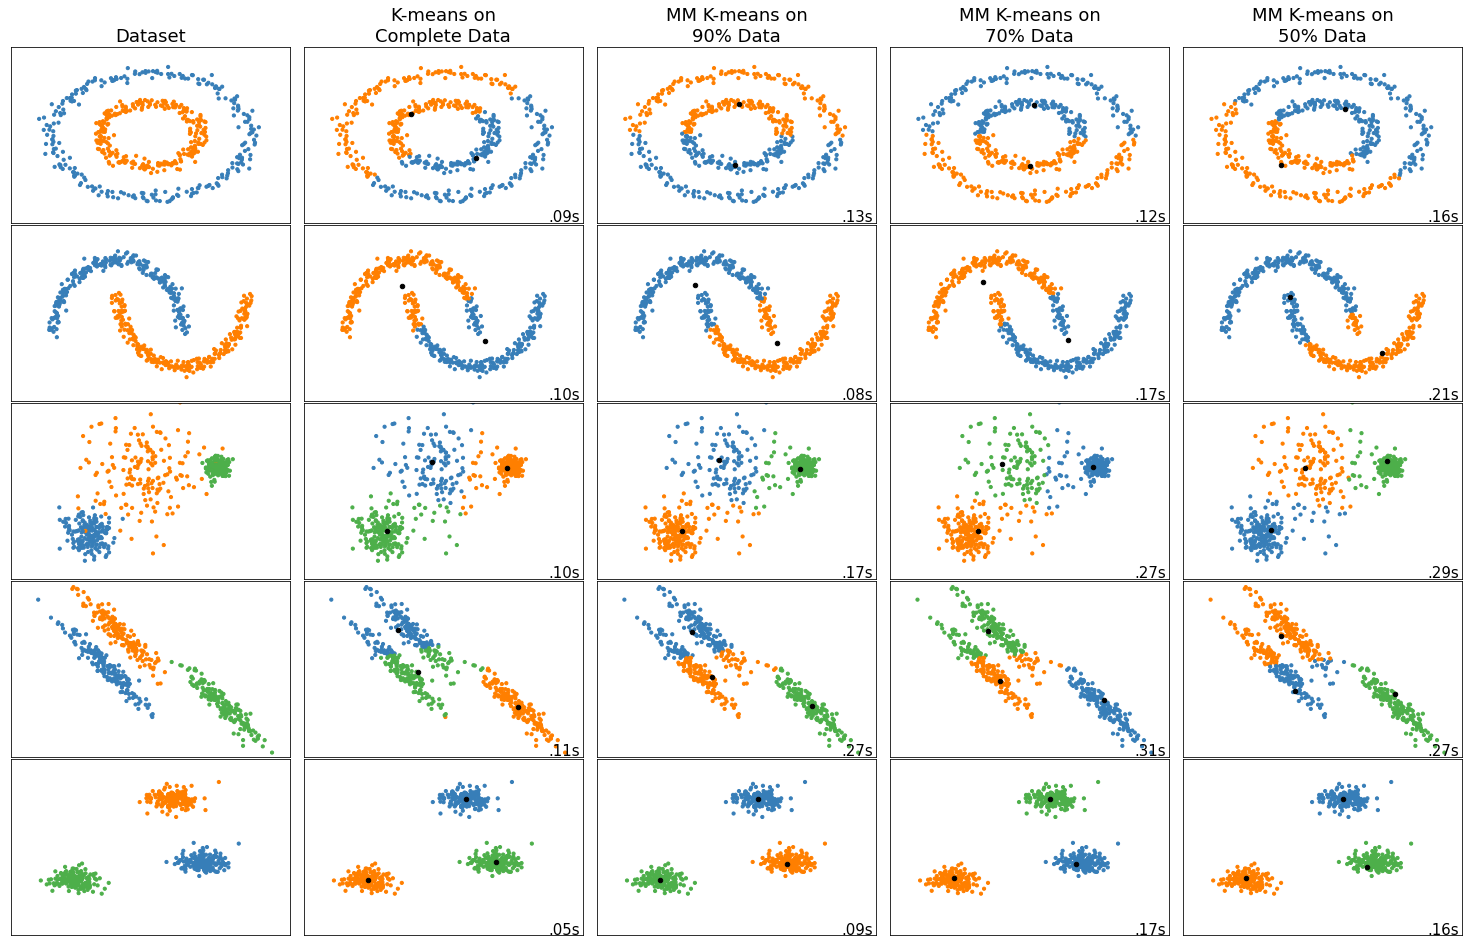

In [566]:
seed_number=0 #change smaple number selected as center
seed_number2=0 #change missing elements
#np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=0)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=0)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=100)
#no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
X, y = datasets.make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)


plot_num = 1

default_base = {
    "max_iter" : 1000, 
    "Seed" : seed_number, 
    "Seed_missingdata" : seed_number2,
    "tolerance" : 10**(-3),
    "n_clusters": 3}

datasets = [
    (noisy_circles, {"n_clusters": 2}),
    (noisy_moons, {"n_clusters": 2}),
    (varied,{}),
    (aniso, {}),
    (blobs, {}),]
    #(no_structure, {})]
    
datasets_name = [
    'noisy_circles',
    'noisy_moons',
    'varied',
    'aniso',
    'blobs',]
    #'no_structure']

print(106 * "_")
print("dataset\t\talgorithm\t\t\ttime\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

#     # ============
    # Create cluster objects
    # ============
    clustering_algorithms = (
        ("Dataset", 'data'),
        ("K-means on\nComplete Data", 'full_set'),
        ("MM K-means on\n90% Data", 'MM_missed10'),
        ("MM K-means on\n70% Data", 'MM_missed30'),
        ("MM K-means on\n50% Data", 'MM_missed50'),
    )
#     clustering_algorithms = (
#         ("Dataset", 'data'),
#         ("K-means on\nComplete Data", 'full_set'),
#         ("K-means on\n90% Data", 'missed10'),
#         ("MM K-means on\n90% Data", 'MM_missed10'),
#         ("K-means on\n70% Data", 'missed30'),
#         ("MM K-means on\n70% Data", 'MM_missed30'),
#         ("K-means on\n50% Data", 'missed50'),
#         ("MM K-means on\n50% Data", 'MM_missed50'),
#     )

    for name, algorithm in clustering_algorithms:  
        t0 = time()
        if algorithm=='data':
            y_pred=np.copy(y)
        if algorithm=='full_set':
            centroids, classifications, loss= kmeans(np.copy(X), k=params["n_clusters"], max_iter=params["max_iter"], 
                                         tolerance=params["tolerance"], Seed=params["Seed"])
        if algorithm=='missed10':
            #Create Incompelete DATASET from Compelete DATASET
            X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=10, 
                                                                   seed_number2=params["Seed_missingdata"])
            #Delete Incompelete Sampeles
            X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
            centroids, classifications, loss= kmeans(np.copy(X_com), k=params["n_clusters"], max_iter=params["max_iter"], 
                                         tolerance=params["tolerance"], Seed=params["Seed"])
            
        if algorithm=='missed30':
            #Create Incompelete DATASET from Compelete DATASET
            X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=30, 
                                                                   seed_number2=params["Seed_missingdata"])
            #Delete Incompelete Sampeles
            X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
            centroids, classifications, loss= kmeans(np.copy(X_com), k=params["n_clusters"], max_iter=params["max_iter"], 
                                         tolerance=params["tolerance"], Seed=params["Seed"])
        if algorithm=='missed50':
            #Create Incompelete DATASET from Compelete DATASET
            X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=50, 
                                                                   seed_number2=params["Seed_missingdata"])
            #Delete Incompelete Sampeles
            X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
            centroids, classifications, loss= kmeans(np.copy(X_com), k=params["n_clusters"], max_iter=params["max_iter"], 
                                         tolerance=params["tolerance"], Seed=params["Seed"])
            
        if algorithm=='MM_missed10':
            #Create Incompelete DATASET from Compelete DATASET
            X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=10, 
                                                                   seed_number2=params["Seed_missingdata"])
            #Delete Incompelete Sampeles
            X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
            centroids, classifications, loss =kmeans_MM(np.copy(X_missed), X_com, sample_index, element_index, 
                                            k=params["n_clusters"], max_iter=params["max_iter"], 
                                            tolerance=params["tolerance"], Seed=params["Seed"])
        if algorithm=='MM_missed30':
            #Create Incompelete DATASET from Compelete DATASET
            X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=30, 
                                                                   seed_number2=params["Seed_missingdata"])
            #Delete Incompelete Sampeles
            X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
            centroids, classifications, loss =kmeans_MM(np.copy(X_missed), X_com, sample_index, element_index, 
                                            k=params["n_clusters"], max_iter=params["max_iter"], 
                                            tolerance=params["tolerance"], Seed=params["Seed"])
        if algorithm=='MM_missed50':
            #Create Incompelete DATASET from Compelete DATASET
            X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=50, 
                                                                   seed_number2=params["Seed_missingdata"])
            #Delete Incompelete Sampeles
            X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
            centroids, classifications, loss =kmeans_MM(np.copy(X_missed), X_com, sample_index, element_index, 
                                            k=params["n_clusters"], max_iter=params["max_iter"], 
                                            tolerance=params["tolerance"], Seed=params["Seed"])

        t1 = time()
        if algorithm!='data':
            y_pred = kmeans_predict(X, centroids)
        bench_k_means(fit_time=t1-t0, name=name.replace('\n'," "), data_name= datasets_name[i_dataset], data=X, labels=y, y_pred=y_pred)
        
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        if algorithm!='data':
            plt.scatter(centroids[:, 0], centroids[:,1], c = "k", s = 20)
#         if algorithm!='data' and algorithm!='full_set':
#             plt.scatter(X[sample_index, 0], X[sample_index, 1], s = 10, facecolors='none', 
#                         edgecolors='r')

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        if algorithm!='data':
            plt.text(
                0.99,
                0.01,
                ("%.2fs" % (t1 - t0)).lstrip("0"),
                transform=plt.gca().transAxes,
                size=15,
                horizontalalignment="right",
            )
        plot_num += 1
print(106 * "_")
plt.show()

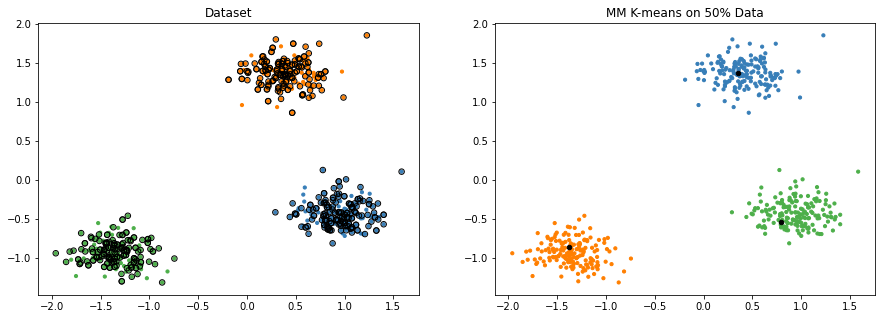

__________________________________________________________________________________________________________
dataset		algorithm			time	homo	compl	v-meas	ARI	AMI	silhouette
blobs    	K-means on Complete Data	0.06	1.000	1.000	1.000	1.000	1.000	0.829
blobs    	MM K-means on 50% Data  	0.20	1.000	1.000	1.000	1.000	1.000	0.829
__________________________________________________________________________________________________________


In [567]:
seed_number=0 #change smaple number selected as center
seed_number2=0 #change missing elements

random_state=100 #change dataset
n_samples = 500
k=3
max_iter=1000
tolerance=10**(-3)

#Create Compelete DATASET
# Make clusters
X, y = make_blobs(n_samples=n_samples, centers = 3, random_state=random_state)
X = StandardScaler().fit_transform(X)
#Create Incompelete DATASET from Compelete DATASET
X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=50, 
                                                       seed_number2=seed_number2)
#Delete Incompelete Sampeles
X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)


#K means test
t0 = time()
centroids1, class1, loss1= kmeans(np.copy(X), k=k, max_iter=max_iter, tolerance=tolerance, Seed=seed_number)
fit_time1 = time() - t0
# t0 = time()
# centroids2, class2, loss2= kmeans(np.copy(X_com), k=k, max_iter=max_iter, tolerance=tolerance, Seed=seed_number)
# fit_time2 = time() - t0
t0 = time()
centroids3, class3, loss3 =kmeans_MM(np.copy(X_missed), X_com, sample_index, element_index, 
                                            k=k, max_iter=max_iter, tolerance=tolerance, Seed=seed_number)
fit_time3 = time() - t0
classifications1 = kmeans_predict(X, centroids1)
# classifications2 = kmeans_predict(X, centroids2)
classifications3 = kmeans_predict(X, centroids3)


colors = np.array(list(islice(cycle([
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a",
                    "#f781bf",
                    "#a65628",
                    "#984ea3",
                    "#999999",
                    "#e41a1c",
                    "#dede00",]),int(max(y_pred) + 1),)))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
# Plot
fig = plt.figure(figsize=(15, 5))
fig.tight_layout()
s1 = plt.subplot(1, 2, 1)
s1.set_title("Dataset")
s1.scatter(X[:, 0], X[:, 1], c = colors[y], s = 10)
s1.scatter(X[sample_index, 0], X[sample_index, 1], s = 30, facecolors='none', edgecolors='k', label='missing data')

# s2 = plt.subplot(1, 3, 2)
# s2.set_title("K-means on Complete Data")
# s2.scatter(X[:, 0], X[:, 1], c = colors[classifications1], s = 10)
# s2.scatter(centroids1[:, 0], centroids1[:,1], c = "k", s = 20)

# s3 = plt.subplot(2, 2, 3)
# s3.set_title("K-means on 50% Data")
# s3.scatter(X[:, 0], X[:, 1], c = colors[classifications2], s = 10)
# s3.scatter(centroids2[:, 0], centroids2[:,1], c = "k", s = 20)


s4 = plt.subplot(1, 2, 2)
s4.set_title("MM K-means on 50% Data")
s4.scatter(X[:, 0], X[:, 1], c = colors[classifications3], s = 10)
s4.scatter(centroids3[:, 0], centroids3[:,1], c = "k", s = 20)
plt.show() 


print(106 * "_")
print("dataset\t\talgorithm\t\t\ttime\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
bench_k_means(fit_time=fit_time1, name="K-means on Complete Data", data_name= 'blobs', data=X, 
              labels=y, y_pred=classifications1)
# bench_k_means(fit_time=fit_time2, name="K-means on 50% Data", data_name= 'blobs', data=X, 
#               labels=y, y_pred=classifications2)
bench_k_means(fit_time=fit_time3, name="MM K-means on 50% Data", data_name= 'blobs', data=X, 
              labels=y, y_pred=classifications3)
print(106 * "_")

In [569]:
# seed_number=0 #change smaple number selected as center
# seed_number2=0 #change missing elements
# #np.random.seed(0)

# # ============
# # Generate datasets. We choose the size big enough to see the scalability
# # of the algorithms, but not too big to avoid too long running times
# # ============
# n_samples = 500
# noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=0)
# noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=0)
# blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
# #no_structure = np.random.rand(n_samples, 2), None

# # Anisotropicly distributed data
# X, y = datasets.make_blobs(n_samples=n_samples, random_state=170)
# transformation = [[0.6, -0.6], [-0.4, 0.8]]
# X_aniso = np.dot(X, transformation)
# aniso = (X_aniso, y)

# # blobs with varied variances
# varied = datasets.make_blobs(
#     n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170
# )

# # ============
# # Set up cluster parameters
# # ============
# plt.figure(figsize=(9 * 2 + 3, 13))
# plt.subplots_adjust(
#     left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
# )


# plot_num = 1

# default_base = {
#     "max_iter" : 1000, 
#     "Seed" : seed_number, 
#     "Seed_missingdata" : seed_number2,
#     "tolerance" : 10**(-3),
#     "n_clusters": 3}

# datasets = [
#     (noisy_circles, {"n_clusters": 2}),
#     (noisy_moons, {"n_clusters": 2}),
#     (varied,{}),
#     (aniso, {}),
#     (blobs, {}),]
#     #(no_structure, {})]
    
# datasets_name = [
#     'noisy_circles',
#     'noisy_moons',
#     'varied',
#     'aniso',
#     'blobs',]
#     #'no_structure']

# print(106 * "_")
# print("dataset\t\talgorithm\t\t\ttime\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
# for i_dataset, (dataset, algo_params) in enumerate(datasets):
#     # update parameters with dataset-specific values
#     params = default_base.copy()
#     params.update(algo_params)
#     X, y = dataset

#     # normalize dataset for easier parameter selection
#     X = StandardScaler().fit_transform(X)

# #     # ============
#     # Create cluster objects
#     # ============
#     clustering_algorithms = (
#         ("Dataset", 'data'),
#         ("K-means on\nComplete Data", 'full_set'),
#         ("K-means on\n90% Data", 'missed10'),
#         ("MM K-means on\n90% Data", 'MM_missed10'),
#         ("K-means on\n70% Data", 'missed30'),
#         ("MM K-means on\n70% Data", 'MM_missed30'),
#         ("K-means on\n50% Data", 'missed50'),
#         ("MM K-means on\n50% Data", 'MM_missed50'),
#     )

#     for name, algorithm in clustering_algorithms:  
#         t0 = time()
#         if algorithm=='data':
#             y_pred=np.copy(y)
#         if algorithm=='full_set':
#             centroids, classifications, loss= kmeans(np.copy(X), k=params["n_clusters"], max_iter=params["max_iter"], 
#                                          tolerance=params["tolerance"], Seed=params["Seed"])
#         if algorithm=='missed10':
#             #Create Incompelete DATASET from Compelete DATASET
#             X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=10, 
#                                                                    seed_number2=params["Seed_missingdata"])
#             #Delete Incompelete Sampeles
#             X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
#             centroids, classifications, loss= kmeans(np.copy(X_com), k=params["n_clusters"], max_iter=params["max_iter"], 
#                                          tolerance=params["tolerance"], Seed=params["Seed"])
            
#         if algorithm=='missed30':
#             #Create Incompelete DATASET from Compelete DATASET
#             X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=30, 
#                                                                    seed_number2=params["Seed_missingdata"])
#             #Delete Incompelete Sampeles
#             X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
#             centroids, classifications, loss= kmeans(np.copy(X_com), k=params["n_clusters"], max_iter=params["max_iter"], 
#                                          tolerance=params["tolerance"], Seed=params["Seed"])
#         if algorithm=='missed50':
#             #Create Incompelete DATASET from Compelete DATASET
#             X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=50, 
#                                                                    seed_number2=params["Seed_missingdata"])
#             #Delete Incompelete Sampeles
#             X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
#             centroids, classifications, loss= kmeans(np.copy(X_com), k=params["n_clusters"], max_iter=params["max_iter"], 
#                                          tolerance=params["tolerance"], Seed=params["Seed"])
            
#         if algorithm=='MM_missed10':
#             #Create Incompelete DATASET from Compelete DATASET
#             X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=10, 
#                                                                    seed_number2=params["Seed_missingdata"])
#             #Delete Incompelete Sampeles
#             X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
#             centroids, classifications, loss =kmeans_MM(np.copy(X_missed), X_com, sample_index, element_index, 
#                                             k=params["n_clusters"], max_iter=params["max_iter"], 
#                                             tolerance=params["tolerance"], Seed=params["Seed"])
#         if algorithm=='MM_missed30':
#             #Create Incompelete DATASET from Compelete DATASET
#             X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=30, 
#                                                                    seed_number2=params["Seed_missingdata"])
#             #Delete Incompelete Sampeles
#             X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
#             centroids, classifications, loss =kmeans_MM(np.copy(X_missed), X_com, sample_index, element_index, 
#                                             k=params["n_clusters"], max_iter=params["max_iter"], 
#                                             tolerance=params["tolerance"], Seed=params["Seed"])
#         if algorithm=='MM_missed50':
#             #Create Incompelete DATASET from Compelete DATASET
#             X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=50, 
#                                                                    seed_number2=params["Seed_missingdata"])
#             #Delete Incompelete Sampeles
#             X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)
#             centroids, classifications, loss =kmeans_MM(np.copy(X_missed), X_com, sample_index, element_index, 
#                                             k=params["n_clusters"], max_iter=params["max_iter"], 
#                                             tolerance=params["tolerance"], Seed=params["Seed"])

#         t1 = time()
#         if algorithm!='data':
#             y_pred = kmeans_predict(X, centroids)
#         bench_k_means(fit_time=t1-t0, name=name.replace('\n'," "), data_name= datasets_name[i_dataset], data=X, labels=y, y_pred=y_pred)
        
#         plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
#         if i_dataset == 0:
#             plt.title(name, size=18)

#         colors = np.array(
#             list(
#                 islice(
#                     cycle(
#                         [
#                             "#377eb8",
#                             "#ff7f00",
#                             "#4daf4a",
#                             "#f781bf",
#                             "#a65628",
#                             "#984ea3",
#                             "#999999",
#                             "#e41a1c",
#                             "#dede00",
#                         ]
#                     ),
#                     int(max(y_pred) + 1),
#                 )
#             )
#         )
#         # add black color for outliers (if any)
#         colors = np.append(colors, ["#000000"])
#         plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
#         if algorithm!='data':
#             plt.scatter(centroids[:, 0], centroids[:,1], c = "k", s = 20)
# #         if algorithm!='data' and algorithm!='full_set':
# #             plt.scatter(X[sample_index, 0], X[sample_index, 1], s = 10, facecolors='none', 
# #                         edgecolors='r')

#         plt.xlim(-2.5, 2.5)
#         plt.ylim(-2.5, 2.5)
#         plt.xticks(())
#         plt.yticks(())
#         if algorithm!='data':
#             plt.text(
#                 0.99,
#                 0.01,
#                 ("%.2fs" % (t1 - t0)).lstrip("0"),
#                 transform=plt.gca().transAxes,
#                 size=15,
#                 horizontalalignment="right",
#             )
#         plot_num += 1
# print(106 * "_")
# plt.show()

In [570]:
# seed_number=0 #change smaple number selected as center
# seed_number2=0 #change missing elements

# random_state=100#8 #change dataset

# n_samples = 500
# k=3
# max_iter=1000
# tolerance=10**(-3)

# #Create Compelete DATASET
# # Make clusters
# X, y = make_blobs(n_samples=n_samples, centers = 3, random_state=random_state)
# X = StandardScaler().fit_transform(X)
# #Create Incompelete DATASET from Compelete DATASET
# X_missed, sample_index, element_index = Create_Incompelete_DATASET(np.copy(X), percentagofmisseddata=50, 
#                                                        seed_number2=seed_number2)
# #Delete Incompelete Sampeles
# X_com, Y_com = Separate_Complete_Data(X_missed, y, sample_index)


# #K means test
# t0 = time()
# centroids1, class1, loss1= kmeans(np.copy(X), k=k, max_iter=max_iter, tolerance=tolerance, Seed=seed_number)
# fit_time1 = time() - t0
# t0 = time()
# centroids2, class2, loss2= kmeans(np.copy(X_com), k=k, max_iter=max_iter, tolerance=tolerance, Seed=seed_number)
# fit_time2 = time() - t0
# t0 = time()
# centroids3, class3, loss3 =kmeans_MM(np.copy(X_missed), X_com, sample_index, element_index, 
#                                             k=k, max_iter=max_iter, tolerance=tolerance, Seed=seed_number)
# fit_time3 = time() - t0
# classifications1 = kmeans_predict(X, centroids1)
# classifications2 = kmeans_predict(X, centroids2)
# classifications3 = kmeans_predict(X, centroids3)


# colors = np.array(list(islice(cycle([
#                     "#377eb8",
#                     "#ff7f00",
#                     "#4daf4a",
#                     "#f781bf",
#                     "#a65628",
#                     "#984ea3",
#                     "#999999",
#                     "#e41a1c",
#                     "#dede00",]),int(max(y_pred) + 1),)))
# # add black color for outliers (if any)
# colors = np.append(colors, ["#000000"])
# # Plot
# fig = plt.figure(figsize=(16, 16))
# fig.tight_layout()
# s1 = plt.subplot(2, 2, 1)
# s1.set_title("Dataset")
# s1.scatter(X[:, 0], X[:, 1], c = colors[y], s = 10)
# s1.scatter(X[sample_index, 0], X[sample_index, 1], s = 30, facecolors='none', edgecolors='k', label='missing data')

# s2 = plt.subplot(2, 2, 2)
# s2.set_title("K-means on Complete Data")
# s2.scatter(X[:, 0], X[:, 1], c = colors[classifications1], s = 10)
# s2.scatter(centroids1[:, 0], centroids1[:,1], c = "k", s = 20)

# s3 = plt.subplot(2, 2, 3)
# s3.set_title("K-means on 50% Data")
# s3.scatter(X[:, 0], X[:, 1], c = colors[classifications2], s = 10)
# s3.scatter(centroids2[:, 0], centroids2[:,1], c = "k", s = 20)

# s4 = plt.subplot(2, 2, 4)
# s4.set_title("MM K-means on 50% Data")
# s4.scatter(X[:, 0], X[:, 1], c = colors[classifications3], s = 10)
# s4.scatter(centroids3[:, 0], centroids3[:,1], c = "k", s = 20)
# plt.show() 


# print(106 * "_")
# print("dataset\t\talgorithm\t\t\ttime\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
# bench_k_means(fit_time=fit_time1, name="K-means on Complete Data", data_name= 'blobs', data=X, 
#               labels=y, y_pred=classifications1)
# bench_k_means(fit_time=fit_time2, name="K-means on 50% Data", data_name= 'blobs', data=X, 
#               labels=y, y_pred=classifications2)
# bench_k_means(fit_time=fit_time3, name="MM K-means on 50% Data", data_name= 'blobs', data=X, 
#               labels=y, y_pred=classifications3)
# print(106 * "_")